# Model with residual connections and batch normalization

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading train, validation and test sets

In [ ]:
ds = tfds.load('malaria', 
               split=('train[:60%]', 'train[60%:80%]'), 
               shuffle_files=False,
              data_dir='/content/gdrive/MyDrive/datasets/Malaria',
               batch_size=32,
              download=True,
              as_supervised=True,
              with_info=False)

# Model building

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=5,
        verbose=1,
        mode="max",
        baseline=None,
        restore_best_weights=True)
    ]

In [ ]:
def build_model(init_filters, kernel_size, num_resid):
    '''I keep the number of filters the same in all layers in this version'''
    inputs = keras.Input(shape=(None, None, 3))
    x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
    x = keras.layers.Conv2D(
      filters=init_filters,
      kernel_size=kernel_size,
      strides=(1, 1),
      padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2), 
        strides=None, 
        padding="same")(x)
    prev_block_output = x
    for i in range(1, num_resid + 1):
        # i is the number of blocks with residual connections
      x = keras.layers.Conv2D(
          filters=init_filters,
          kernel_size=kernel_size,
          strides=(1, 1),
          padding="same")(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation("relu")(x)
      x = keras.layers.Conv2D(
          filters=init_filters,
          kernel_size=kernel_size,
          strides=(1, 1),
          padding="same")(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation("relu")(x)
      x = keras.layers.add([x, prev_block_output])
      prev_block_output = x
    x = keras.layers.Conv2D(
        filters=init_filters,
        kernel_size=kernel_size,
        strides=(1, 1),
        padding="same")(prev_block_output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.GlobalMaxPooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=init_filters,
                            activation="relu",
                          kernel_regularizer=None)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='Adam',
         loss='binary_crossentropy',
         metrics=['accuracy'])    
    return model

In [ ]:
model = build_model(64, 4, 6)

In [ ]:
history = model.fit(
    ds[0],
    epochs=50,
    verbose="auto",
    callbacks=callbacks,
    validation_data=ds[1]
)

Epoch 1/50
517/517 [==============================] - 465s 873ms/step - loss: 0.2136 - accuracy: 0.9348 - val_loss: 0.2066 - val_accuracy: 0.9316
Epoch 2/50
517/517 [==============================] - 242s 469ms/step - loss: 0.1481 - accuracy: 0.9561 - val_loss: 0.1560 - val_accuracy: 0.9599
Epoch 3/50
517/517 [==============================] - 243s 469ms/step - loss: 0.1453 - accuracy: 0.9562 - val_loss: 0.1558 - val_accuracy: 0.9588
Epoch 4/50
517/517 [==============================] - 242s 469ms/step - loss: 0.1421 - accuracy: 0.9574 - val_loss: 0.1302 - val_accuracy: 0.9574
Epoch 5/50
517/517 [==============================] - 243s 469ms/step - loss: 0.1383 - accuracy: 0.9583 - val_loss: 0.1290 - val_accuracy: 0.9632
Epoch 6/50
517/517 [==============================] - 242s 468ms/step - loss: 0.1355 - accuracy: 0.9583 - val_loss: 0.1409 - val_accuracy: 0.9559
Epoch 7/50
517/517 [==============================] - 243s 469ms/step - loss: 0.1316 - accuracy: 0.9587 - val_loss: 0.1486 -

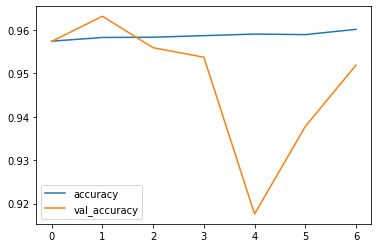

In [ ]:
pd.DataFrame({'accuracy': history.history['accuracy'][3:],
              'val_accuracy': history.history['val_accuracy'][3:]}).plot.line();

In [ ]:
max(history.history['val_accuracy'])

0.9631645679473877

In [ ]:
model_2 = build_model(16, 3, 6)

In [ ]:
history_2 = model_2.fit(
    ds[0],
    epochs=50,
    verbose="auto",
    callbacks=callbacks,
    validation_data=ds[1]
)

Epoch 1/50
517/517 [==============================] - 113s 214ms/step - loss: 0.2853 - accuracy: 0.8815 - val_loss: 0.2814 - val_accuracy: 0.8993
Epoch 2/50
517/517 [==============================] - 46s 89ms/step - loss: 0.1530 - accuracy: 0.9554 - val_loss: 0.1299 - val_accuracy: 0.9581
Epoch 3/50
517/517 [==============================] - 46s 89ms/step - loss: 0.1478 - accuracy: 0.9545 - val_loss: 0.3432 - val_accuracy: 0.8980
Epoch 4/50
517/517 [==============================] - 45s 88ms/step - loss: 0.1419 - accuracy: 0.9568 - val_loss: 0.1816 - val_accuracy: 0.9463
Epoch 5/50
517/517 [==============================] - 45s 88ms/step - loss: 0.1376 - accuracy: 0.9586 - val_loss: 0.2012 - val_accuracy: 0.9356
Epoch 6/50
517/517 [==============================] - 47s 90ms/step - loss: 0.1354 - accuracy: 0.9583 - val_loss: 0.1289 - val_accuracy: 0.9606
Epoch 7/50
517/517 [==============================] - 46s 90ms/step - loss: 0.1331 - accuracy: 0.9593 - val_loss: 0.1428 - val_accurac

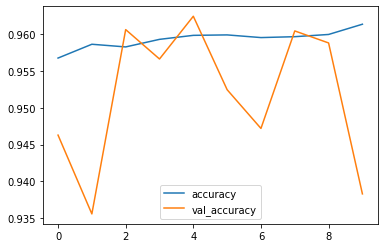

In [ ]:
pd.DataFrame({'accuracy': history_2.history['accuracy'][3:],
              'val_accuracy': history_2.history['val_accuracy'][3:]}).plot.line();

In [ ]:
max(history_2.history['val_accuracy'])

0.9624387621879578

Validation accuracy of the 1st model resumed growth before ealry stopping. Can it improve further?

In [ ]:
history = model.fit(
    ds[0],
    epochs=50,
    verbose="auto",
    callbacks=callbacks,
    validation_data=ds[1]
)

Epoch 1/50
517/517 [==============================] - 243s 469ms/step - loss: 0.1461 - accuracy: 0.9562 - val_loss: 0.1666 - val_accuracy: 0.9510
Epoch 2/50
517/517 [==============================] - 242s 469ms/step - loss: 0.1372 - accuracy: 0.9584 - val_loss: 0.1319 - val_accuracy: 0.9590
Epoch 3/50
517/517 [==============================] - 242s 469ms/step - loss: 0.1337 - accuracy: 0.9586 - val_loss: 0.2398 - val_accuracy: 0.9193
Epoch 4/50
517/517 [==============================] - 242s 469ms/step - loss: 0.1299 - accuracy: 0.9593 - val_loss: 0.2004 - val_accuracy: 0.9378
Epoch 5/50
517/517 [==============================] - 242s 468ms/step - loss: 0.1270 - accuracy: 0.9590 - val_loss: 0.1664 - val_accuracy: 0.9508
Epoch 6/50
517/517 [==============================] - 242s 468ms/step - loss: 0.1238 - accuracy: 0.9600 - val_loss: 0.1507 - val_accuracy: 0.9595
Epoch 7/50
517/517 [==============================] - 242s 468ms/step - loss: 0.1231 - accuracy: 0.9618 - val_loss: 0.1926 -

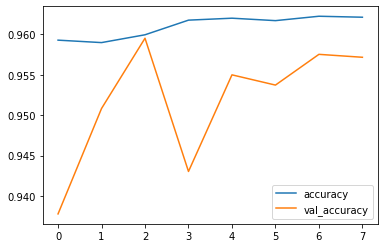

In [ ]:
pd.DataFrame({'accuracy': history.history['accuracy'][3:],
              'val_accuracy': history.history['val_accuracy'][3:]}).plot.line();

In [ ]:
max(history.history['val_accuracy'])

0.9595354795455933

Continued training did not improve accuracy.

#Conclusion
Batch normalization did not improve accuracy but accelerated convergence (fewer epochs).